In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abcd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abcd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load dataset
df = pd.read_csv("SentimentData.csv")

In [3]:
# Define column names
text_column = "statement"  # Text data
label_column = "status"  # Sentiment labels

# Display basic info
print("🔹 Dataset Information:")
print(df.info())

# Check for missing values
print("\n🔹 Missing Values in Dataset:")
print(df.isnull().sum())

# Check first few rows
print("\n🔹 Sample Data:")
print(df.head())

# Check class distribution
print("\n🔹 Class Distribution:")
print(df[label_column].value_counts())

# Convert labels to categorical if not already
df[label_column] = df[label_column].astype("category")


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None

🔹 Missing Values in Dataset:
Unnamed: 0      0
statement     362
status          0
dtype: int64

🔹 Sample Data:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

🔹 Class Distribution:
status
Normal                  163

In [7]:
import numpy as np

# Text length (number of words per entry)
df["word_count"] = df[text_column].apply(lambda x: len(str(x).split()))

# Sentence count per entry
df["sentence_count"] = df[text_column].apply(lambda x: len(str(x).split(".")))

# Average word length per entry
df["avg_word_length"] = df[text_column].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# Count of unique words per entry
df["unique_word_count"] = df[text_column].apply(lambda x: len(set(str(x).split())))

# Calculate lexical diversity (unique words / total words)
df["lexical_diversity"] = df["unique_word_count"] / df["word_count"]

# Display summary statistics
print("\n🔹 Text-Based Statistics:")
print(df[["word_count", "sentence_count", "avg_word_length", "unique_word_count", "lexical_diversity"]].describe())

# Check extremely short or long texts
print("\n🔹 Shortest and Longest Texts:")
print(f"Shortest Text: {df.loc[df['word_count'].idxmin(), text_column]}")
print(f"Longest Text: {df.loc[df['word_count'].idxmax(), text_column]}")


🔹 Text-Based Statistics:
         word_count  sentence_count  avg_word_length  unique_word_count  \
count  53043.000000    53043.000000     53043.000000       53043.000000   
mean     112.393285        6.975793         4.316473          68.727334   
std      163.436684       11.836290        13.822561          75.156407   
min        1.000000        1.000000         1.100000           1.000000   
25%       15.000000        1.000000         3.821032          14.000000   
50%       61.000000        4.000000         4.090909          48.000000   
75%      147.500000        9.000000         4.428571          97.000000   
max     6300.000000     1261.000000      3161.875000        1775.000000   

       lexical_diversity  
count       53043.000000  
mean            0.787306  
std             0.167522  
min             0.000794  
25%             0.652381  
50%             0.783333  
75%             0.956522  
max             1.000000  

🔹 Shortest and Longest Texts:
Shortest Text: Anxious
L

In [11]:
# Check imbalance in classes
label_counts = df[label_column].value_counts()
max_class = label_counts.max()
min_class = label_counts.min()
imbalance_ratio = max_class / min_class

print("\n🔹 Sentiment Class Imbalance Ratio:")
print(f"Most frequent class has {imbalance_ratio:.2f}x more samples than least frequent class.")

# Display minority class samples
minority_class = label_counts.idxmin()
print(f"\n🔹 Example Texts from Minority Class '{minority_class}':")
print(df[df[label_column] == minority_class][text_column].sample(5, random_state=42))


🔹 Sentiment Class Imbalance Ratio:
Most frequent class has 13.61x more samples than least frequent class.

🔹 Example Texts from Minority Class 'Personality disorder':
50897    my guinea pig passed and now there's just me i...
51678    My first therapy appointment in a long time I ...
50887    Is it okay to appear rude to others? I find it...
50724    Why is AVPD considered a personality disorder ...
51017    DAE feel like nobody will ever love you? And b...
Name: statement, dtype: object


In [9]:
# Drop rows with missing 'statement' values
df.dropna(subset=['statement'], inplace=True)

# Display unique values in 'status' (sentiment/emotion category)
print("\nUnique Status Values:\n", df['status'].value_counts())


Unique Status Values:
 status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\3501630430.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='coolwarm', order=df['status'].value_counts().index)


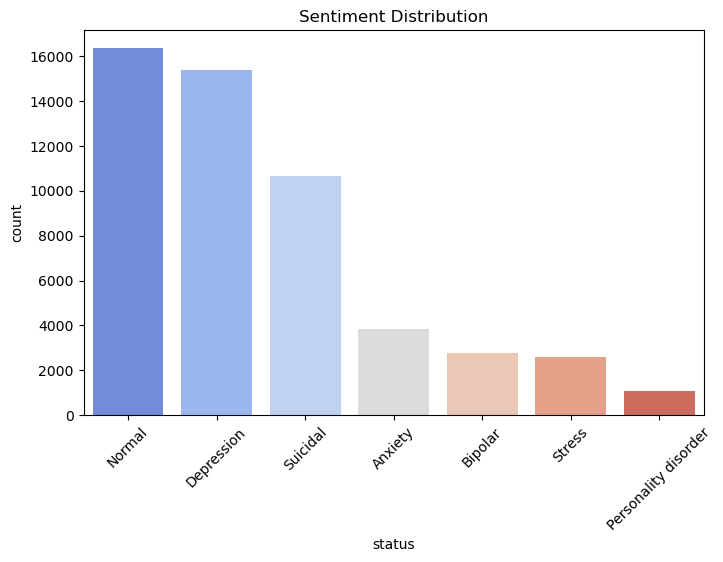

In [65]:
# Plot status (sentiment) distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='status', data=df, palette='coolwarm', order=df['status'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.show()

In [73]:
# Generate Word Cloud for the text data
text_data = ' '.join(df['statement'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS).generate(text_data)

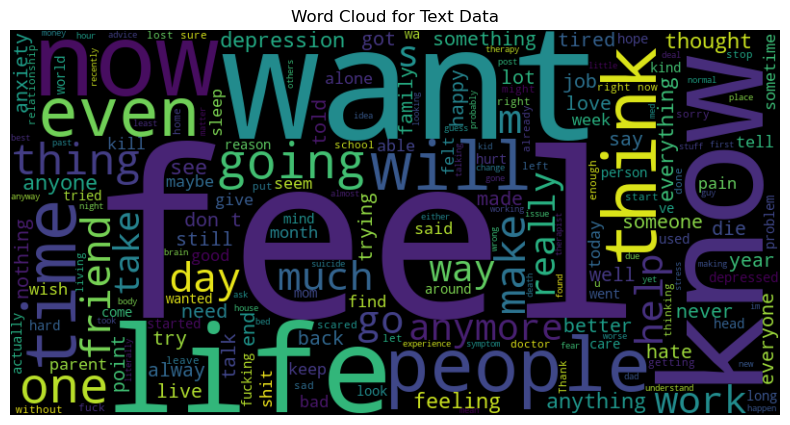

In [77]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Data')
plt.show()

In [79]:
# Most common words analysis
stop_words = set(stopwords.words('english'))
all_words = word_tokenize(text_data.lower())
filtered_words = [word for word in all_words if word.isalnum() and word not in stop_words]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2015097689.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')


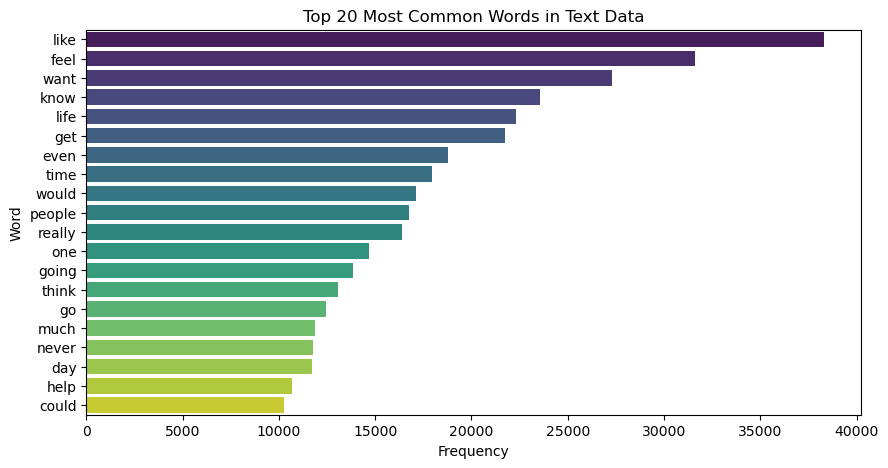

In [80]:
# Plot most common words
plt.figure(figsize=(10, 5))
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')
plt.title('Top 20 Most Common Words in Text Data')
plt.show()

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2133421457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='text_length', data=df, palette='coolwarm')


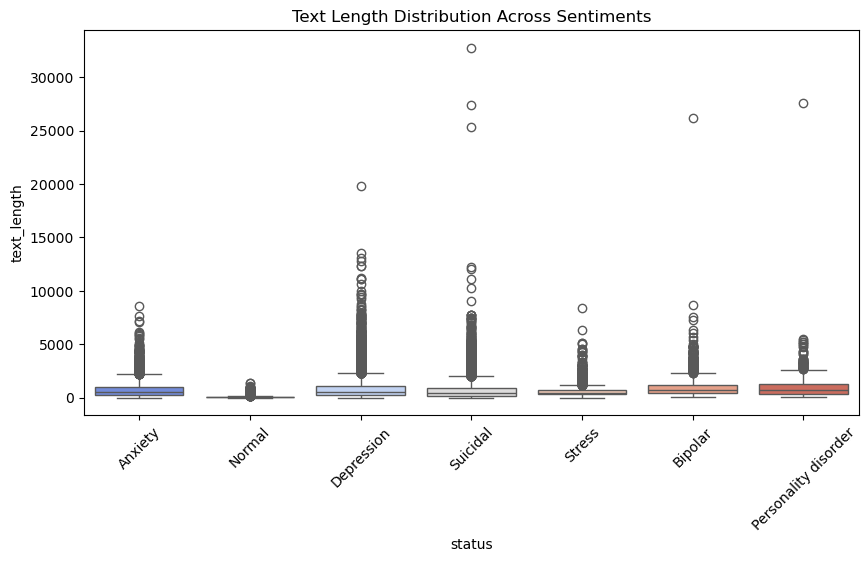

In [83]:
# Sentiment-wise text length analysis
plt.figure(figsize=(10, 5))
sns.boxplot(x='status', y='text_length', data=df, palette='coolwarm')
plt.title('Text Length Distribution Across Sentiments')
plt.xticks(rotation=45)
plt.show()

In [87]:
# Bi-gram and Tri-gram Analysis
def get_ngrams(text, n=2):
    words = [word for word in word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]
    return list(nltk.ngrams(words, n))

bigrams = get_ngrams(text_data, 2)
trigrams = get_ngrams(text_data, 3)

bigram_counts = Counter(bigrams).most_common(15)
trigram_counts = Counter(trigrams).most_common(15)

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\190669552.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='coolwarm')


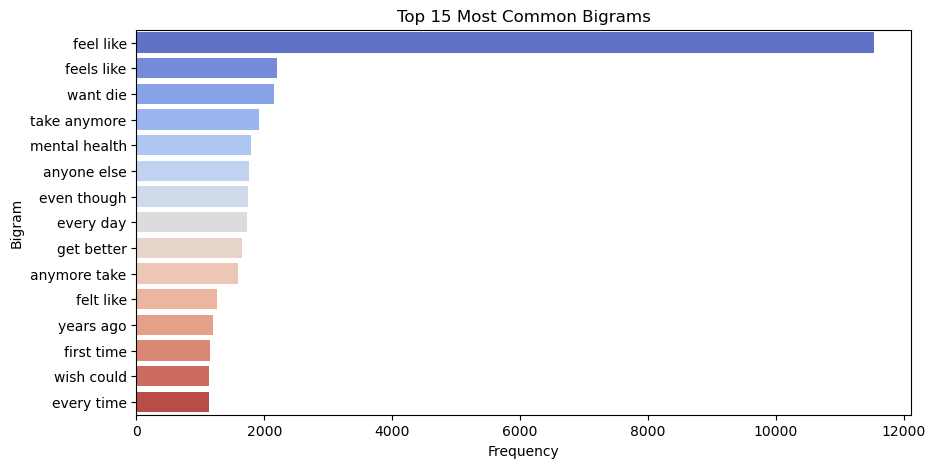

In [88]:
# Plot bigrams
plt.figure(figsize=(10, 5))
bigram_df = pd.DataFrame(bigram_counts, columns=['Bigram', 'Frequency'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='coolwarm')
plt.title('Top 15 Most Common Bigrams')
plt.show()

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\3360990782.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Trigram', data=trigram_df, palette='magma')


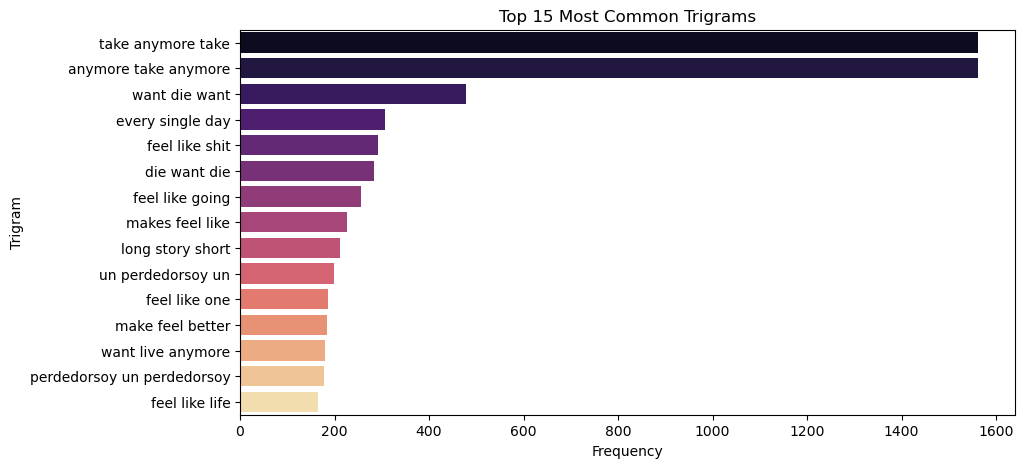

In [89]:
# Plot trigrams
plt.figure(figsize=(10, 5))
trigram_df = pd.DataFrame(trigram_counts, columns=['Trigram', 'Frequency'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='Frequency', y='Trigram', data=trigram_df, palette='magma')
plt.title('Top 15 Most Common Trigrams')
plt.show()

In [93]:
# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['statement'].dropna())
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\1703388354.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='Word', data=tfidf_df, palette='cividis')


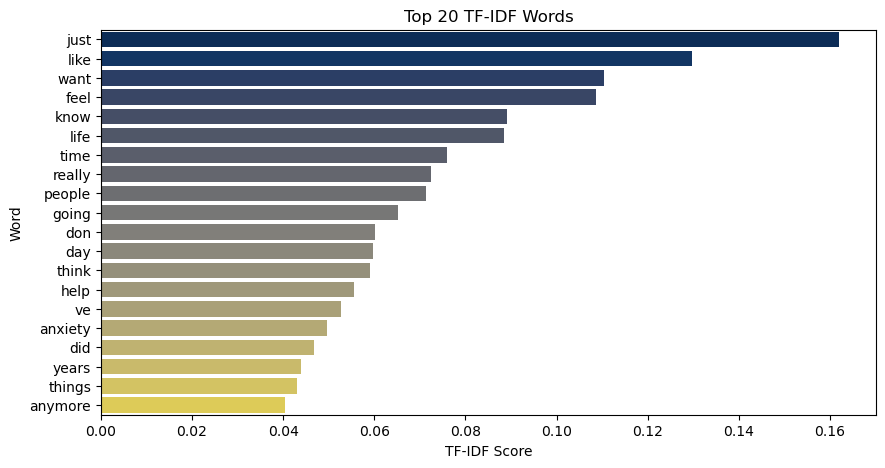

In [95]:
# Plot TF-IDF scores
plt.figure(figsize=(10, 5))
tfidf_df = pd.DataFrame({'Word': tfidf_feature_names, 'TF-IDF Score': tfidf_values})
tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)
sns.barplot(x='TF-IDF Score', y='Word', data=tfidf_df, palette='cividis')
plt.title('Top 20 TF-IDF Words')
plt.show()

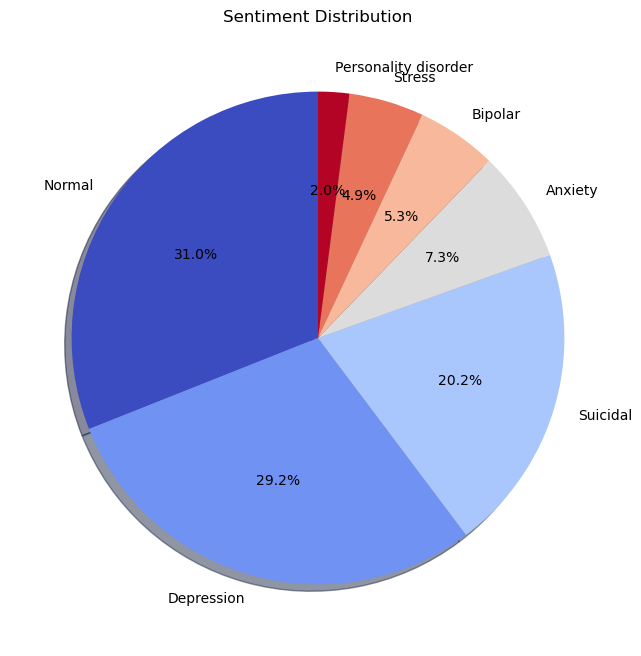

In [97]:
plt.figure(figsize=(8, 8))
df['status'].value_counts().plot.pie(autopct='%1.1f%%', cmap='coolwarm', startangle=90, shadow=True)
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


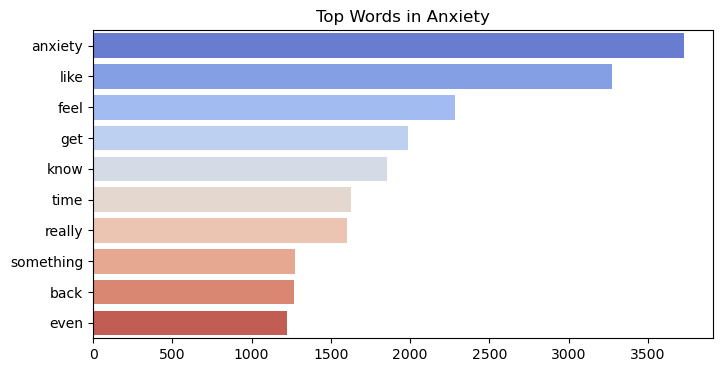

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


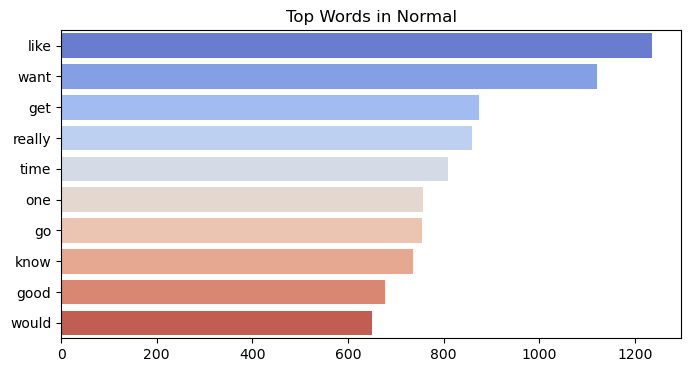

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


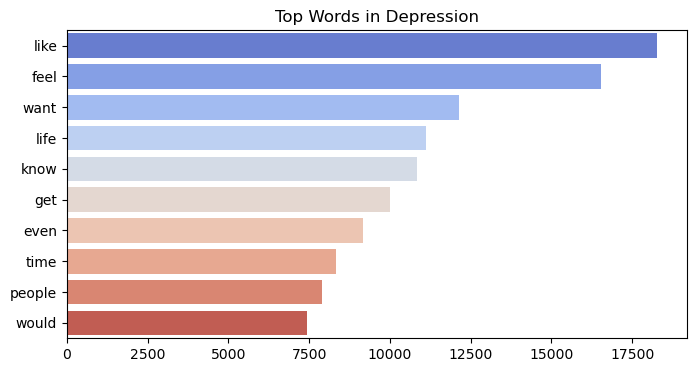

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


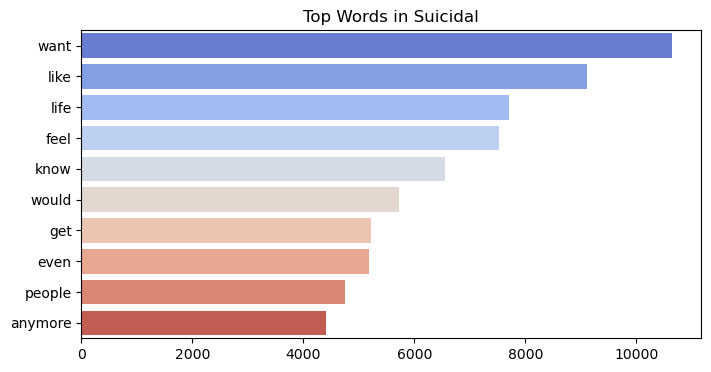

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


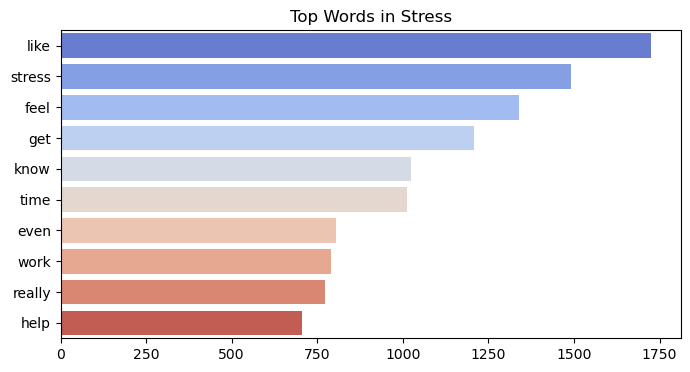

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


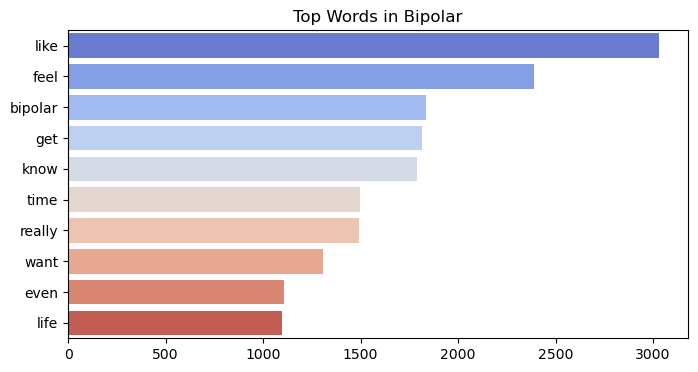

C:\Users\abcd\AppData\Local\Temp\ipykernel_16492\2578338908.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='coolwarm')


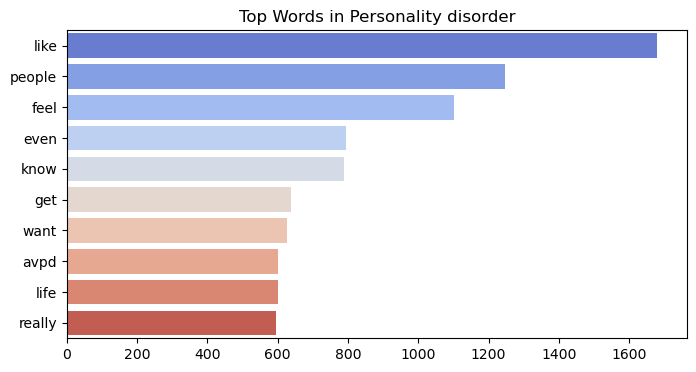

In [101]:
from collections import defaultdict

category_word_count = defaultdict(Counter)

for _, row in df.iterrows():
    words = word_tokenize(str(row['statement']).lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    category_word_count[row['status']].update(filtered_words)

for category, counter in category_word_count.items():
    common_words = counter.most_common(10)
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts), y=list(words), palette='coolwarm')
    plt.title(f'Top Words in {category}')
    plt.show()

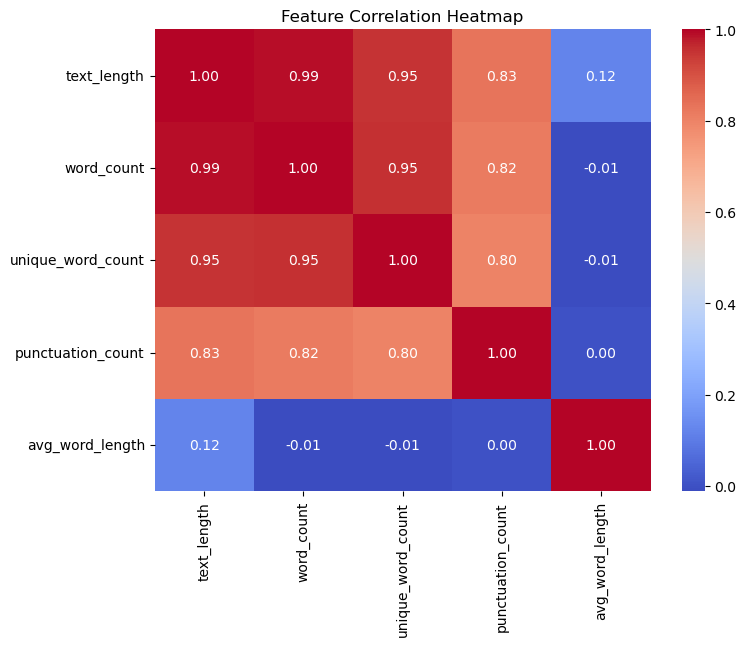

In [105]:
corr = df[['text_length', 'word_count', 'unique_word_count', 'punctuation_count', 'avg_word_length']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

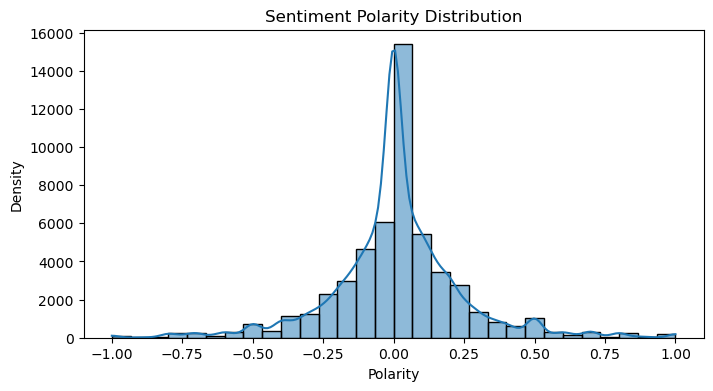

In [11]:
from textblob import TextBlob

df['polarity'] = df['statement'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['statement'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Polarity Distribution Plot
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['polarity'], kde=True, bins=30)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Density")
plt.show()

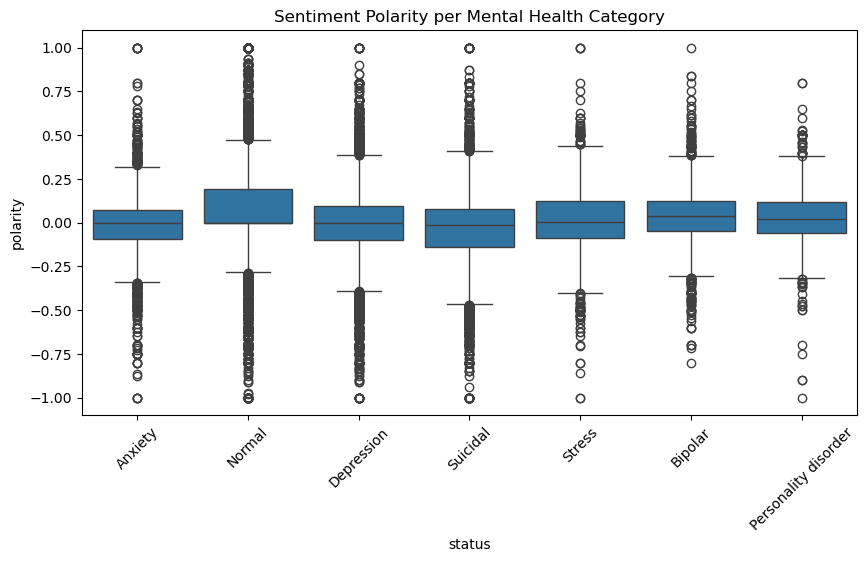

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['status'], y=df['polarity'])
plt.title("Sentiment Polarity per Mental Health Category")
plt.xticks(rotation=45)
plt.show()

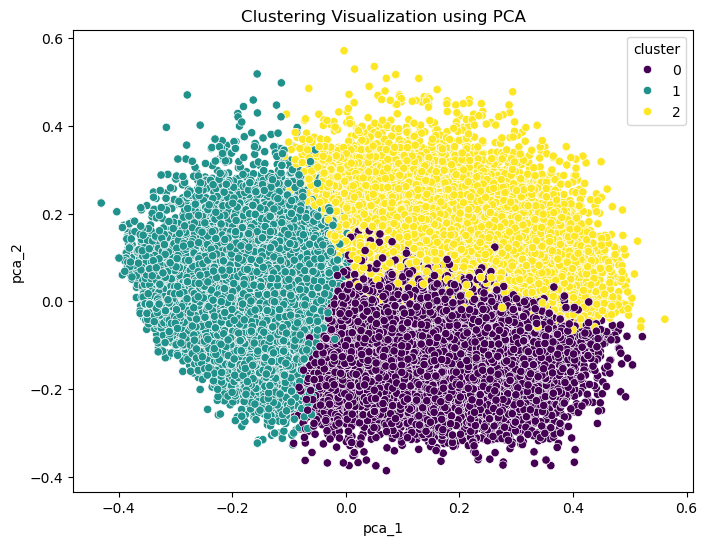

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df['statement'].dropna())
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Ensure that we only use rows that were processed by TF-IDF
df_valid = df.loc[df['statement'].notna()].copy()  # Only keep non-null rows
X_valid = vectorizer.fit_transform(df_valid['statement'])  # Fit TF-IDF on the same subset

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_valid['cluster'] = kmeans.fit_predict(X_valid)

# PCA for Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_valid.toarray())

df_valid['pca_1'] = pca_result[:, 0]
df_valid['pca_2'] = pca_result[:, 1]

# Scatter Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_valid['pca_1'], y=df_valid['pca_2'], hue=df_valid['cluster'], palette='viridis')
plt.title("Clustering Visualization using PCA")
plt.show()